In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import vision
from fastai import metrics

In [4]:
# List of avaialble functionalities

dir(vision)

['AUROC',
 'AccumulateScheduler',
 'AdamW',
 'AdaptiveConcatPool2d',
 'AffineFunc',
 'AffineMatrix',
 'AnnealFunc',
 'Any',
 'AnyStr',
 'ArgStar',
 'AverageMetric',
 'BCEFlat',
 'BCEWithLogitsFlat',
 'BatchNorm1dFlat',
 'BatchSampler',
 'BatchSamples',
 'BnFreeze',
 'BoolOrTensor',
 'BufferedWriter',
 'ByteTensor',
 'BytesIO',
 'Callable',
 'Callback',
 'CallbackHandler',
 'CallbackList',
 'Category',
 'CategoryList',
 'CategoryProcessor',
 'ClassificationInterpretation',
 'Collection',
 'Config',
 'ConfusionMatrix',
 'CoordFunc',
 'Counter',
 'CrossEntropyFlat',
 'DataBunch',
 'DataFrame',
 'DataFrameOrChunks',
 'DataLoader',
 'Dataset',
 'DatasetType',
 'Debugger',
 'DeviceDataLoader',
 'Dict',
 'DistributedDataParallel',
 'DoubleTensor',
 'EmptyLabel',
 'EmptyLabelList',
 'Enum',
 'ExpRMSPE',
 'ExplainedVariance',
 'F',
 'FBeta',
 'FilePathList',
 'Flatten',
 'FlattenedLoss',
 'FloatItem',
 'FloatList',
 'FloatOrTensor',
 'FloatTensor',
 'Floats',
 'FlowField',
 'GradientClipping',


# Data Exploration

In [5]:
path = vision.untar_data(vision.URLs.CIFAR_100)
path

PosixPath('/root/.fastai/data/cifar100')

In [6]:
img_path = sum([x.ls() for x in path.ls()[0].ls()], [])
len(img_path)

100

In [7]:
fn_path = sum([x.ls() for x in img_path], [])
fn_path[:2]

[PosixPath('/root/.fastai/data/cifar100/train/large_man-made_outdoor_things/bridge/lift_bridge_s_000268.png'),
 PosixPath('/root/.fastai/data/cifar100/train/large_man-made_outdoor_things/bridge/lift_bridge_s_001482.png')]

In [0]:
tfms = vision.get_transforms(do_flip=False)

In [0]:
# Both works. First use the regualr expression to get class anme while other used the labels list.
pat = r"/(\w+)/[a-zA-Z0-9_-]+.png$"
data = vision.ImageDataBunch.from_name_re(path, fn_path, pat=pat, ds_tfms=tfms, size=96)

#labels = [str(x).split("/")[-2] for x in fn_path]
#data = vision.ImageDataBunch.from_lists(path, fn_path, labels = labels, ds_tfms=tfms, size=96)

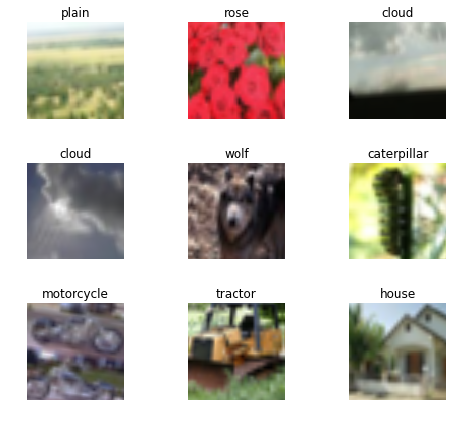

In [10]:
data.show_batch(rows=3,  figsize=(7,6))

In [11]:
print(data.classes)
data.c

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

100

# ResNet34 Training

In [0]:
learn = vision.cnn_learner(data, vision.models.resnet34, metrics=metrics.error_rate)

In [13]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,2.417879,1.740964,0.461800,02:05
1,1.658872,1.200538,0.354800,02:03
2,1.398488,1.041995,0.314700,02:01
3,1.281646,0.954123,0.291400,02:01
4,1.177116,0.906964,0.274700,02:02
5,1.094360,0.865310,0.264500,02:05
6,1.025185,0.841169,0.257600,02:11
7,0.959055,0.835948,0.256400,02:14


In [0]:
learn.save('cifar100-baseline')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


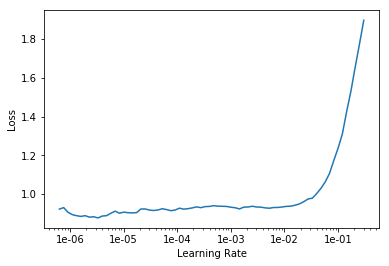

In [15]:
learn.lr_find()
learn.recorder.plot()

In [16]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,1.373374,1.056043,0.308700,02:32
1,0.976110,0.797789,0.238900,02:34
2,0.574057,0.720889,0.213500,02:35


In [0]:
learn.save('cifar100-update1')

In [19]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.533051,0.750735,0.217700,02:33
1,0.444323,0.715589,0.204900,02:34
2,0.335923,0.710751,0.200700,02:36


In [0]:
learn.save('cifar100-update2')

# Classification Interpretation

In [21]:
interp = vision.ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

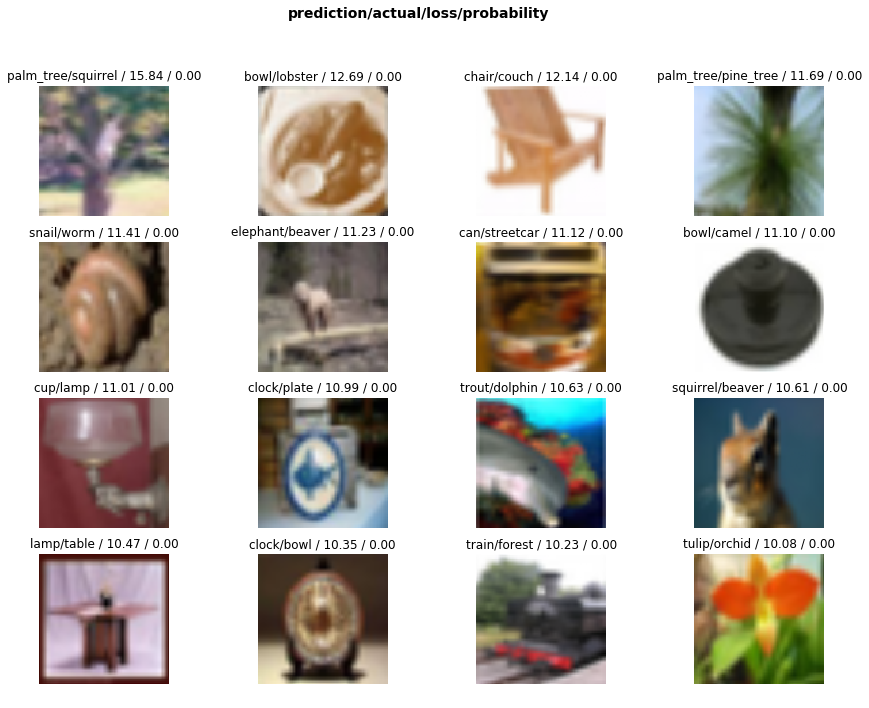

In [23]:
interp.plot_top_losses(16, figsize=(15,11))

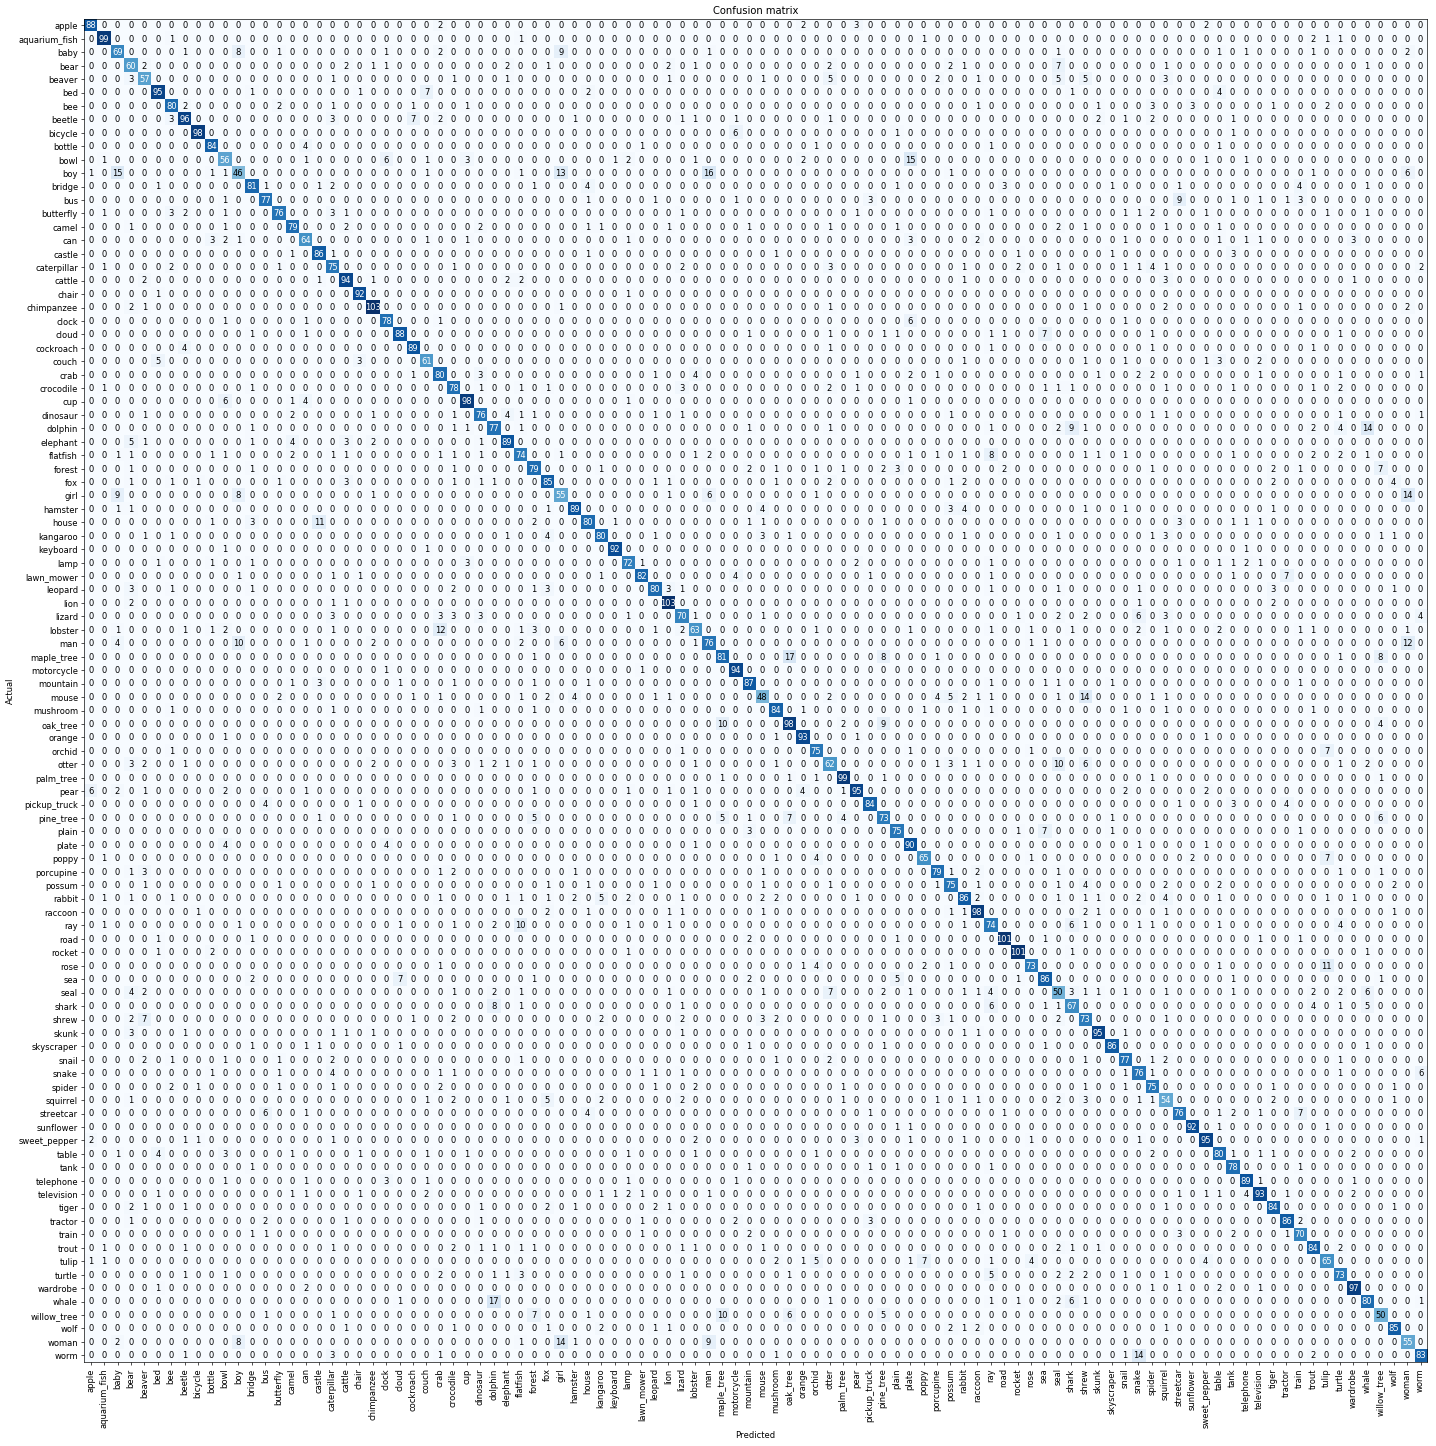

In [25]:
interp.plot_confusion_matrix(figsize=(24, 24), dpi=60)

In [27]:
interp.most_confused(min_val=10)

[('maple_tree', 'oak_tree', 17),
 ('whale', 'dolphin', 17),
 ('boy', 'man', 16),
 ('bowl', 'plate', 15),
 ('boy', 'baby', 15),
 ('dolphin', 'whale', 14),
 ('girl', 'woman', 14),
 ('mouse', 'shrew', 14),
 ('woman', 'girl', 14),
 ('worm', 'snake', 14),
 ('boy', 'girl', 13),
 ('lobster', 'crab', 12),
 ('man', 'woman', 12),
 ('house', 'castle', 11),
 ('rose', 'tulip', 11),
 ('man', 'boy', 10),
 ('oak_tree', 'maple_tree', 10),
 ('otter', 'seal', 10),
 ('ray', 'flatfish', 10),
 ('willow_tree', 'maple_tree', 10)]

# ResNet50 Training

In [37]:
learn = vision.cnn_learner(data, vision.models.resnet50, metrics=metrics.error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:04<00:00, 21271739.18it/s]


In [38]:
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,error_rate,time
0,1.845414,1.348598,0.382000,02:51
1,1.330006,1.016131,0.302400,02:51
2,1.167120,0.872380,0.262600,02:50
3,1.027236,0.793719,0.240300,02:49
4,0.867885,0.751282,0.230400,02:49
5,0.799695,0.744926,0.227800,02:49


In [0]:
learn.save('cifar100-baseline')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


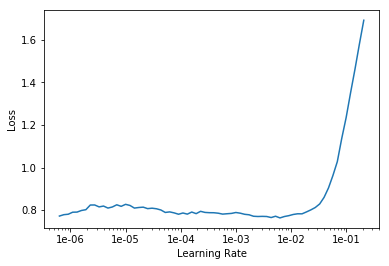

In [40]:
learn.lr_find()
learn.recorder.plot()

In [41]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,1.288689,1.002414,0.296700,03:45
1,1.038999,0.877414,0.256600,03:43
2,0.598319,0.696296,0.201400,03:44
3,0.324076,0.669913,0.184400,03:44


In [0]:
learn.save('cifar100-update1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


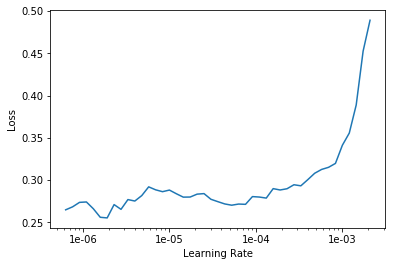

In [44]:
learn.lr_find()
learn.recorder.plot()

In [45]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.300909,0.659644,0.182300,03:44
1,0.275512,0.661313,0.179200,03:45
2,0.227814,0.664048,0.177600,03:44
3,0.213038,0.668601,0.179700,03:46


In [0]:
learn.save('cifar100-update2')

# Classification Interpretation

In [50]:
interp = vision.ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

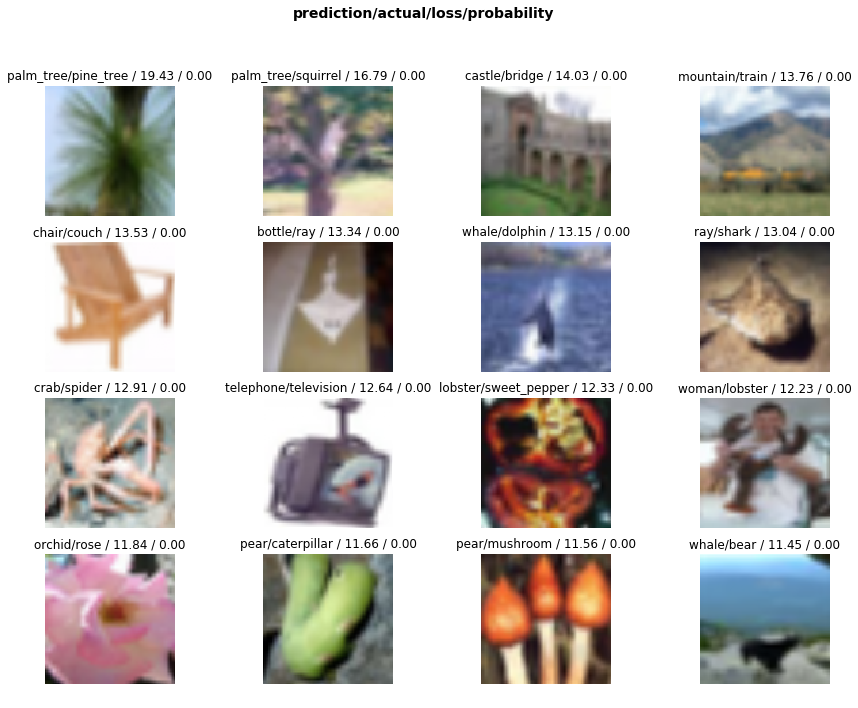

In [51]:
interp.plot_top_losses(16, figsize=(15,11))

In [52]:
interp.most_confused(min_val=4)

[('girl', 'woman', 18),
 ('bowl', 'plate', 16),
 ('maple_tree', 'oak_tree', 16),
 ('boy', 'man', 15),
 ('oak_tree', 'maple_tree', 15),
 ('girl', 'boy', 14),
 ('woman', 'girl', 14),
 ('boy', 'baby', 13),
 ('boy', 'girl', 13),
 ('man', 'woman', 13),
 ('woman', 'man', 13),
 ('mouse', 'shrew', 12),
 ('willow_tree', 'maple_tree', 12),
 ('pine_tree', 'oak_tree', 11),
 ('whale', 'dolphin', 11),
 ('baby', 'girl', 10),
 ('dolphin', 'shark', 10),
 ('dolphin', 'whale', 10),
 ('otter', 'seal', 10),
 ('ray', 'flatfish', 10),
 ('snake', 'worm', 10),
 ('worm', 'snake', 10),
 ('beetle', 'cockroach', 9),
 ('bus', 'streetcar', 9),
 ('forest', 'willow_tree', 9),
 ('lizard', 'caterpillar', 9),
 ('poppy', 'tulip', 9),
 ('shrew', 'mouse', 9),
 ('plain', 'sea', 8),
 ('plate', 'bowl', 8),
 ('willow_tree', 'oak_tree', 8),
 ('bicycle', 'motorcycle', 7),
 ('boy', 'woman', 7),
 ('chimpanzee', 'bear', 7),
 ('cloud', 'sea', 7),
 ('cockroach', 'beetle', 7),
 ('crab', 'lobster', 7),
 ('girl', 'baby', 7),
 ('house', '